In [ ]:
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import lasio
from pyesmda import ESMDA
from scipy.io import loadmat
from numdifftools import Jacobian, Hessian
from scipy import signal, stats, linalg, optimize

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

def check_torch():
    torch_version, cuda_avail = torch.__version__, torch.cuda.is_available()
    count, name = torch.cuda.device_count(), torch.cuda.get_device_name()
    print('\n'+'-'*60)
    print('----------------------- VERSION INFO -----------------------')
    print('Torch version: {} | Torch Built with CUDA? {}'.format(torch_version, cuda_avail))
    print('# Device(s) available: {}, Name(s): {}'.format(count, name))
    print('-'*60+'\n')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    return device

device = check_torch()

In [ ]:
def plot_curve(ax, df, curve, lb=None, ub=None, color='k', pad=0, s=2, ms=2, mult=1,
            units:str=None, mask=None, offset:int=0, title:str=None, label:str=None,
            semilog:bool=False, bar:bool=False, fill:bool=None, rightfill:bool=False,
            marker=None, edgecolor=None, ls=None, alpha=None, grid_alpha=0.5):
        if mask is None:
            x, y = -offset+mult*df[curve], df.index
        else:
            x, y = -offset+mult*df[curve][mask], df.index[mask]
        lb = x[~np.isnan(x)].min() if lb is None else lb
        ub = x[~np.isnan(x)].max() if ub is None else ub
        if semilog:
            ax.semilogx(x, y, c=color, label=curve, alpha=alpha,
                        marker=marker, markersize=ms, markeredgecolor=edgecolor, linestyle=ls, linewidth=s)
        else:
            if bar:
                ax.barh(y, x, color=color, label=curve, alpha=alpha)
            else:
                ax.plot(x, y, c=color, label=curve, alpha=alpha, marker=marker, markersize=ms, markeredgecolor=edgecolor, linewidth=s, linestyle=ls)
        if fill:
            if rightfill:
                ax.fill_betweenx(y, x, ub, alpha=alpha, color=color)
            else:
                ax.fill_betweenx(y, lb, x, alpha=alpha, color=color)
        if units is None:
            if hasattr(df, 'curvesdict'):
                units = df.curvesdict[curve].unit
            else:
                units = ''
        ax.set_xlim(lb, ub)
        ax.grid(True, which='both',alpha=grid_alpha)
        ax.set_title(title, weight='bold') if title != None else None
        xlab = label if label is not None else curve
        if offset != 0:
            ax.set_xlabel('{} [{}] with {} offset'.format(xlab, units, offset), color=color, weight='bold')
        else:
            ax.set_xlabel('{} [{}]'.format(xlab, units), color=color, weight='bold')
        ax.xaxis.set_label_position('top'); ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_tick_params(color=color, width=s)
        ax.spines['top'].set_position(('axes', 1+pad/100))
        ax.spines['top'].set_edgecolor(color); ax.spines['top'].set_linewidth(2)
        if ls is not None:
            ax.spines['top'].set_linestyle(ls)
        return None

def plot_loss(losses_df, figsize=(6,4)):
    plt.figure(figsize=figsize)
    plt.plot(losses_df['train'], label='Training')
    plt.plot(losses_df['valid'], label='Validation')
    plt.xlabel('Epochs'); plt.ylabel('Loss')
    plt.xlim(0, losses_df.shape[0]); plt.ylim(0, None)
    plt.grid(True, which='both'); plt.legend()
    plt.tight_layout(); plt.show()
    return None

In [267]:
class ResInvPINN(nn.Module):
    def __init__(self, hidden_dim:int=128, csh_constraint_mult=1.0):
        super(ResInvPINN, self).__init__()
        self.fc1  = nn.Linear(2, hidden_dim)
        self.fc2  = nn.Linear(hidden_dim, hidden_dim)
        self.fc3  = nn.Linear(hidden_dim, 2)
        self.mult = csh_constraint_mult

    def constraints(self, d):
        c, s = d[:, 0], d[:, 1]
        c = self.mult * torch.sigmoid(c)
        return torch.stack([c, s], dim=-1)
       
    def forward(self, x):
        x = x[:, :2]
        
        x = self.fc1(x)
        x = nn.Tanh()(x)

        x = self.fc2(x)
        x = nn.Tanhshrink()(x)

        x = self.fc3(x)
        x = self.constraints(x)

        return x

class PINNLoss(nn.Module):
    def __init__(self, dd_flag:bool=True, ddmax=1.0, lambda_reg=1e-10, lambda_p=2):
        super(PINNLoss, self).__init__()
        self.lambda_reg = lambda_reg
        self.lambda_p   = lambda_p
        self.dd_flag    = dd_flag
        self.ddmax      = ddmax

    def forward(self, inputs, outputs):
        Rv_true  = inputs[:, 0]
        Rh_true  = inputs[:, 1]
        dd_true  = inputs[:, 2]/self.ddmax
        Rvsh     = inputs[:, 3]
        Rhsh     = inputs[:, 4]
        
        Csh_pred = outputs[:, 0]
        Rss_pred = outputs[:, 1]

        eq1 = (Csh_pred*Rvsh + (1-Csh_pred)*Rss_pred) - (Rv_true)
        eq2 = (1/(Csh_pred/Rhsh + (1-Csh_pred)/Rss_pred)) - (Rh_true)
        eqs = torch.stack([eq1, eq2], dim=-1)

        if self.dd_flag:
            wd1, wd2 = 1/Rv_true/dd_true, 1/Rh_true/dd_true
        else:
            wd1, wd2 = 1/Rv_true, 1/Rh_true
        Wdm = torch.stack([wd1, wd2], dim=-1)

        costf = torch.norm(torch.matmul(Wdm.T, eqs), p=2)
        regPa = self.lambda_reg * torch.norm(outputs, p=self.lambda_p)

        return  costf + regPa
    
class DataLoss(nn.Module):
    def __init__(self, loss_fn=nn.MSELoss(), lambda_p=2):
        super(DataLoss, self).__init__()
        self.dd_loss = loss_fn
        self.lambda_p = lambda_p

    def forward(self, inputs, outputs):
        Rv_true  = inputs[:, 0]
        Rh_true  = inputs[:, 1]
        dd_true  = inputs[:, 2]
        Rvsh     = inputs[:, 3]
        Rhsh     = inputs[:, 4]

        Csh_pred = outputs[:, 0]
        Rss_pred = outputs[:, 1]
        
        Rv_sim = (Csh_pred*Rvsh + (1-Csh_pred)*Rss_pred)
        Rh_sim = 1 / (Csh_pred/Rhsh + (1-Csh_pred)/Rss_pred)
        v_loss = self.dd_loss(Rv_sim, Rv_true)
        h_loss = self.dd_loss(Rh_sim, Rh_true)
        
        return torch.norm(torch.stack([v_loss, h_loss], dim=-1), p=self.lambda_p)

***
# Dataset 1 Analysis

In [577]:
# Chevron 2009 (HW1)
start, end = 9620, 10200
d1 = lasio.read('datasets/hw1_data/LASOut_ALL_W18.las').df()#.loc[start:end]

In [578]:
# clean sand, clean shale (10068.5, 9651.0)
sand_point, shale_point = 10068.5, 9651.0
print('Shale point: {:.1f} | Sand point: {:.1f}'.format(shale_point, sand_point))

# Csh (gamma ray index 'igr')
d1['Rvsh'], d1['Rhsh'] = 2.813, 0.775
gmin, gmax = d1['GR'].min(), d1['GR'].max()
d1['igr'] = (d1['GR'] - gmin) / (gmax - gmin)
csh = MinMaxScaler((0.005,0.995)).fit_transform(d1['igr'].values.reshape(-1, 1)).flatten()

# porosity
phi_d_corr = (d1['PHID_SS'] - csh * d1.loc[shale_point, 'PHID_SS']) / (1-csh)
phi_n_corr = (d1['TNPH'] - csh * d1.loc[shale_point, 'TNPH']) / (1-csh)
phi_ss = 0.5*np.sqrt(phi_d_corr**2 + phi_n_corr**2)
d1['phi_t'] = (1-csh)*phi_ss + csh*phi_ss.loc[shale_point]

# resistivity & saturation
a, m, n = 1.0, 2.3, 2.0
rw = d1['AT90'][sand_point] * d1['PHID_SS'][sand_point]**m
rs = (1-csh) / ((1/d1['AT10'])-(csh/d1['AT10'].loc[shale_point]))
sw = ((a*rw) / (rs*d1['phi_t']**m))**(1/n)
d1['sw'] = sw.interpolate('polynomial', order=5).clip(0.01,0.99)
d1['shc'] = 1-d1['sw']

# permeability | a[100,1000], b[2,4], c[1.5,4]
aa, bb, cc = 10, 2.5, 1.5
d1['perm'] = (aa * d1['phi_t']**bb) / (d1['sw']**cc)

Shale point: 9651.0 | Sand point: 10068.5


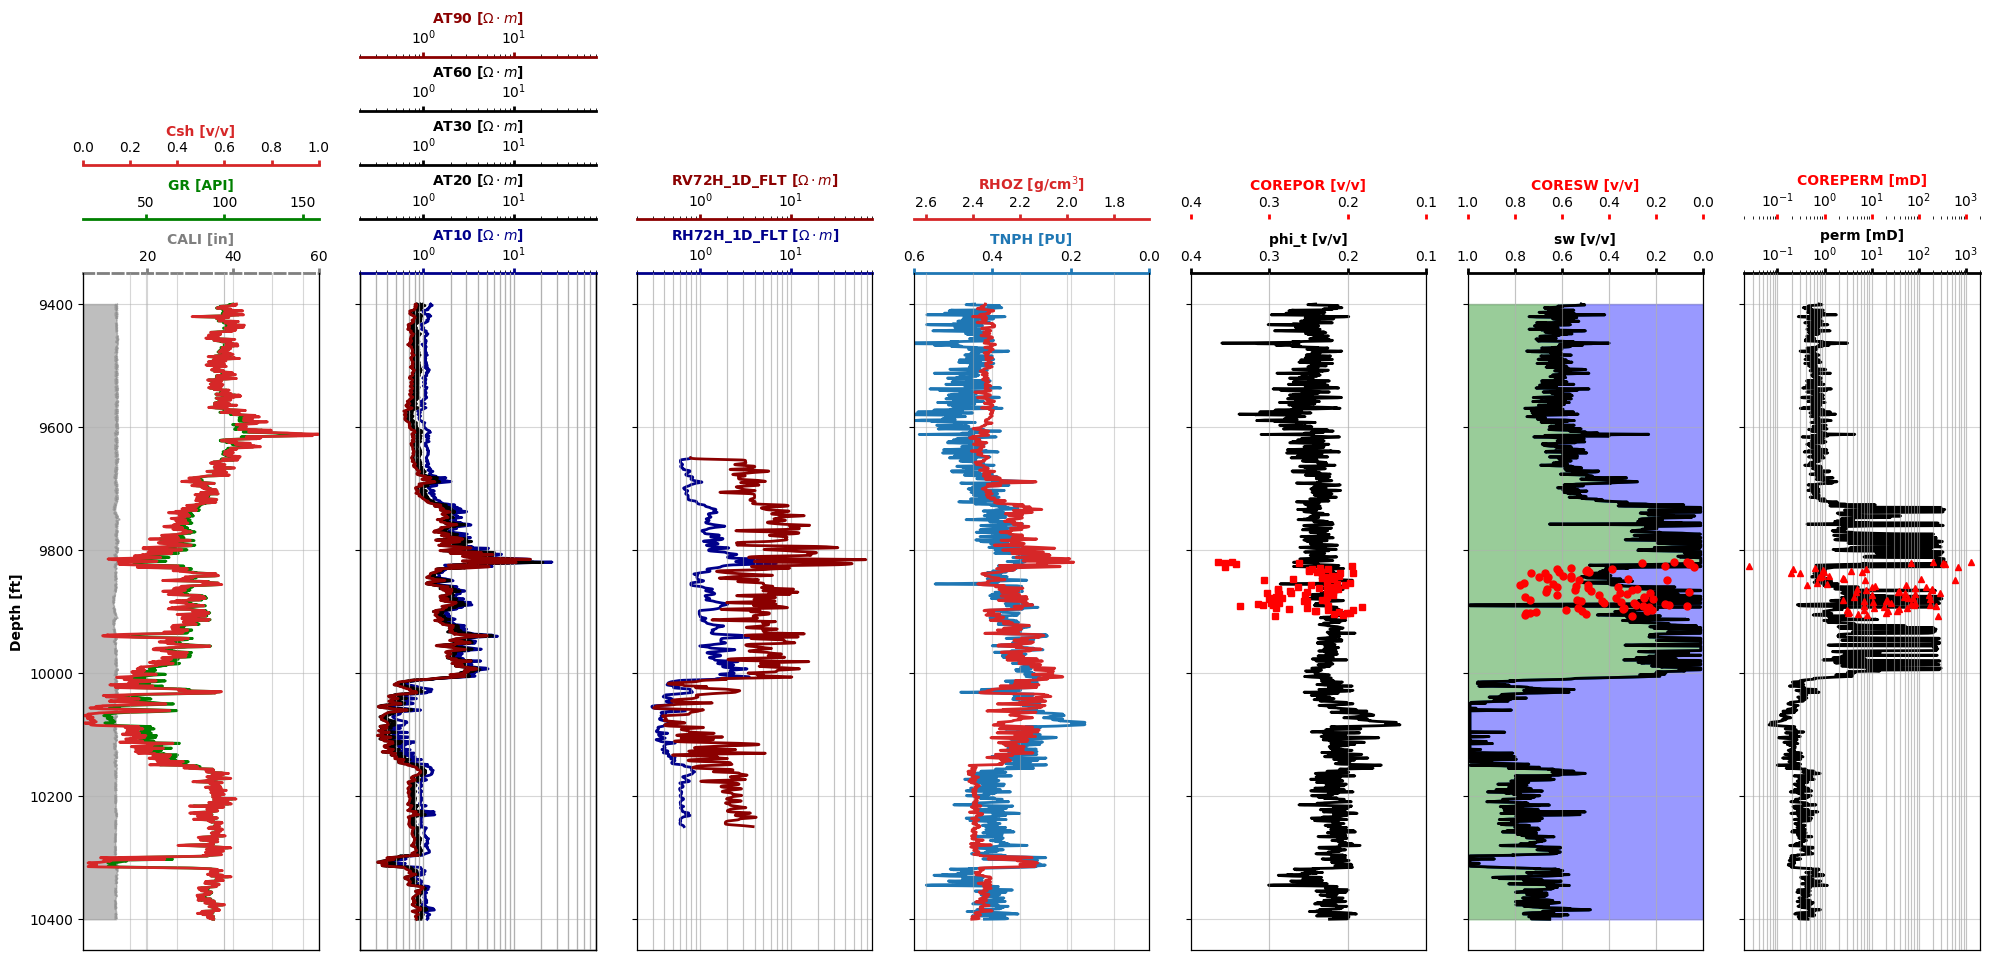

In [579]:
rlb, rub = 0.2, 80
fig, axs = plt.subplots(1, 7, figsize=(20, 10), sharey=True)
ax1, ax2, ax3, ax4, ax5, ax6, ax7 = axs
ax11, ax12 = ax1.twiny(), ax1.twiny()
ax21, ax22, ax23, ax24 = ax2.twiny(), ax2.twiny(), ax2.twiny(), ax2.twiny()
ax31, ax41, ax51, ax61, ax71 = ax3.twiny(), ax4.twiny(), ax5.twiny(), ax6.twiny(), ax7.twiny()

plot_curve(ax1, d1, 'CALI', lb=5, ub=60, units='in', color='tab:gray', ls='--', alpha=0.5, fill=True)
plot_curve(ax11, d1, 'GR', units='API', lb=10, ub=160, color='g', pad=8)
plot_curve(ax12, d1, 'igr', lb=0, ub=1, units='v/v', label='Csh', color='tab:red', pad=16)

plot_curve(ax2, d1, 'AT10', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkblue', semilog=True)
plot_curve(ax21, d1, 'AT20', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='k', semilog=True, pad=8)
plot_curve(ax22, d1, 'AT30', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='k', semilog=True, pad=16)
plot_curve(ax23, d1, 'AT60', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='k', semilog=True, pad=24)
plot_curve(ax24, d1, 'AT90', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkred', semilog=True, pad=32)

plot_curve(ax3, d1, 'RH72H_1D_FLT', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkblue', semilog=True)
plot_curve(ax31, d1, 'RV72H_1D_FLT', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkred', semilog=True, pad=8)

plot_curve(ax4, d1, 'TNPH', units='PU', lb=0.6, ub=0.0, color='tab:blue')
plot_curve(ax41, d1, 'RHOZ', units=r'g/cm$^3$', lb=2.65, ub=1.65, color='tab:red', pad=8)

plot_curve(ax5, d1, 'phi_t', lb=0.4, ub=0.1, units='v/v', color='k')
plot_curve(ax51, d1, 'COREPOR', lb=0.4, ub=0.1, units='v/v', color='r', ls='', marker='s', ms=5, pad=8)

plot_curve(ax6, d1, 'sw', lb=1, ub=0, units='v/v', color='g', fill=True, alpha=0.4)
plot_curve(ax6, d1, 'sw', lb=1, ub=0, units='v/v', color='b', fill=True, rightfill=True, alpha=0.4)
plot_curve(ax6, d1, 'sw', lb=1, ub=0, units='v/v', color='k')
plot_curve(ax61, d1, 'CORESW', lb=1, ub=0, units='v/v', color='r', ls='', marker='o', ms=5, pad=8)

plot_curve(ax7, d1, 'perm', lb=0.02, ub=2000, units='mD', color='k', semilog=True)
plot_curve(ax71, d1, 'COREPERM', lb=0.02, ub=2000, units='mD', color='r', ls='', marker='^', ms=5, semilog=True, pad=8)

ax1.set_ylabel('Depth [ft]', color='k', weight='bold')
#ax1.set_ylim(9810, 9910)
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

In [580]:
res1 = d1[['RV72H_1D_FLT', 'RH72H_1D_FLT', 'GR', 'Rvsh', 'Rhsh', 'RHOZ', 'TNPH', 'PHID_SS', 'AT10', 'AT90']].dropna()
res1.columns = ['Rv', 'Rh', 'GR', 'Rvsh', 'Rhsh', 'RHOB', 'NPHI', 'PHID_SS', 'AT10', 'AT90']

inputs = torch.tensor(res1.values, dtype=torch.float32).to(device)
dataset = TensorDataset(inputs)
train_percent = 0.8
n_train = int(train_percent*len(dataset))
xtrain, xvalid = random_split(dataset, [n_train, len(dataset)-n_train])
print('X_train: {} | X_valid: {}'.format(len(xtrain), len(xvalid)))

batch_size = 32
trainloader = DataLoader(xtrain, batch_size=batch_size, shuffle=True)
validloader = DataLoader(xvalid, batch_size=batch_size, shuffle=False)

model = ResInvPINN(hidden_dim=128).to(device)
criterion = PINNLoss(ddmax=res1['GR'].max(), lambda_reg=0, dd_flag=True).to(device)
mseloss = DataLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print('# of parameters: {:,}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

epochs, monitor = 301, 100
pinn_lambda = 0.85
train_loss, valid_loss = [], []
for epoch in range(epochs):
    # training
    epoch_train_loss = []
    model.train()
    for i, x in enumerate(trainloader):
        optimizer.zero_grad()
        y = model(x[0])
        loss = (pinn_lambda)*criterion(x[0],y) + (1-pinn_lambda)*mseloss(x[0],y)
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())
    train_loss.append(np.mean(epoch_train_loss))
    # validation
    model.eval()
    epoch_valid_loss = []
    with torch.no_grad():
        for i, x in enumerate(validloader):
            y = model(x[0])
            loss = (pinn_lambda)*criterion(x[0],y) + (1-pinn_lambda)*mseloss(x[0],y)
            epoch_valid_loss.append(loss.item())
    valid_loss.append(np.mean(epoch_valid_loss))
    # progress
    if epoch % monitor == 0:
        print('Epoch: {} | Loss: {:.4f} | Valid Loss: {:.4f}'.format(epoch, train_loss[-1], valid_loss[-1]))

losses = (train_loss, valid_loss)

X_train: 1919 | X_valid: 480
# of parameters: 17,154
Epoch: 0 | Loss: 43.8954 | Valid Loss: 33.7088
Epoch: 100 | Loss: 3.9459 | Valid Loss: 3.4553
Epoch: 200 | Loss: 5.1041 | Valid Loss: 6.2609
Epoch: 300 | Loss: 3.1702 | Valid Loss: 5.2038


In [581]:
y_pred = model(inputs[:,:2]).cpu().detach().numpy().squeeze()
Csh_pred, Rss_pred = [y_pred[:,i] for i in range(y_pred.shape[1])]
print('Csh: min: {:.3f} | max: {:.3f}'.format(Csh_pred.min(), Csh_pred.max()))

Rv_true = res1['Rv'].values
Rh_true = res1['Rh'].values
Rvsh    = res1['Rvsh'].values
Rhsh    = res1['Rhsh'].values

Rv_sim = (Csh_pred*Rvsh + (1-Csh_pred)*Rss_pred)
Rh_sim = 1/(Csh_pred/Rhsh + (1-Csh_pred)/Rss_pred)
Rv_err = np.abs((Rv_sim - Rv_true)/Rv_true) * 100
Rh_err = np.abs((Rh_sim - Rh_true)/Rh_true) * 100

Csh: min: 0.024 | max: 0.789


In [583]:
# porosity
phi_d_corr = (res1['PHID_SS'] - Csh_pred * d1.loc[shale_point, 'PHID_SS']) / (1-Csh_pred)
phi_n_corr = (res1['NPHI'] - Csh_pred * d1.loc[shale_point, 'TNPH']) / (1-Csh_pred)
phi_ss = 0.5*np.sqrt(phi_d_corr**2 + phi_n_corr**2)
phi_pinn = (1-Csh_pred)*phi_ss + Csh_pred*phi_ss.mean()

# resistivity & saturation
a, m, n = 1.0, 2.3, 2.0
rw = res1['AT90'][sand_point] * res1['PHID_SS'][sand_point]**m
rs = (1-Csh_pred) / ((1/res1['AT10'])-(Csh_pred/res1['AT10'].loc[shale_point]))
sw = ((a*rw) / (rs*phi_pinn**m))**(1/n)
sw_pinn = sw.interpolate('polynomial', order=5).clip(0.01,0.99)

# permeability | a[100,1000], b[2,4], c[1.5,4]
aa, bb, cc = 10, 2.5, 1.5
perm_pinn = (aa * phi_pinn**bb) / (sw_pinn**cc)

In [1099]:
dduq = {}
nuq = 300
for i in range(nuq):
    dduq[i] = res1 + np.random.normal(0, 0.25*res1.std(0), size=res1.shape)

csh_uq = np.zeros((nuq, res1.shape[0]))
rss_uq = np.zeros((nuq, res1.shape[0]))
poro_prior = np.zeros((nuq, res1.shape[0]))

for i in tqdm(range(nuq), desc='Uncertainty quantification'):
    xx = torch.tensor(dduq[i][['Rv','Rh']].values, dtype=torch.float32).to(device)
    rr = model(xx).cpu().detach().numpy().squeeze()
    csh_uq[i], rss_uq[i] = rr[:,0], rr[:,1]

    d = (res1['PHID_SS'] - csh_uq[i] * d1.loc[shale_point, 'PHID_SS']) / (1-csh_uq[i])
    n = (res1['NPHI'] - csh_uq[i] * d1.loc[shale_point, 'TNPH']) / (1-csh_uq[i])
    s = 0.5*np.sqrt(d**2 + n**2)
    poro_prior[i] = (1-csh_uq[i])*s + csh_uq[i]*s.mean()

print('Prior - Porosity: {} | Sw: {} | Permeability: {}'.format(poro_prior.shape, sw_prior.shape, perm_prior.shape))

Uncertainty quantification: 100%|██████████| 300/300 [00:00<00:00, 456.87it/s]

Prior - Porosity: (300, 2399) | Sw: (200, 2399) | Permeability: (200, 2399)


In [1100]:
def esmda_assimilation(X_prior, y_obs, obs_idx, R=None, n_iter=4, gamma=1.5):
    n_ens, n_state = X_prior.shape
    n_obs = len(obs_idx)
    H = np.eye(n_state)[obs_idx]
    alpha1 = (1-gamma) / (1-gamma**n_iter)
    alpha_factors = np.array([alpha1 * gamma**(i) for i in range(n_iter)])
    if R is None:
        R = np.eye(n_obs) * 0.05
    X = X_prior.copy()
    for i in range(n_iter):
        Y = X @ H.T
        A = X - X.mean(axis=0)
        YA = Y - Y.mean(axis=0)
        alpha = alpha_factors[i]
        R_scaled = R * alpha
        Y_pert = y_obs + np.random.multivariate_normal(np.zeros(n_obs), R_scaled, size=n_ens)
        Cxy = (A.T @ YA) / (n_ens - 1)
        Cyy = (YA.T @ YA) / (n_ens - 1) + R_scaled
        K = Cxy @ np.linalg.pinv(Cyy)
        X += (Y_pert - Y) @ K.T
    return signal.medfilt(X, kernel_size=(1,5))

In [1101]:
def esmda_parameter_estimation(theta_prior, y_obs, obs_idx, forward_model, R=None, n_iter=4, gamma=1.5, log:bool=False):
    n_ens, n_params = theta_prior.shape
    n_obs = len(y_obs)
    if log:
        y_obs = np.log10(y_obs)
    alpha1 = (1 - gamma) / (1 - gamma**n_iter)
    alpha_factors = np.array([alpha1 * gamma**(i) for i in range(n_iter)])
    R = np.eye(n_obs) * 0.05 if R is None else R
    theta = theta_prior.copy()
    for i in range(n_iter):
        alpha = alpha_factors[i]
        R_scaled = R * alpha
        Y = forward_model(theta)[:, obs_idx]
        if log:
            Y = np.log10(Y)
        Y_pert = y_obs + np.random.multivariate_normal(np.zeros(n_obs), R_scaled, size=n_ens)
        A_theta = theta - theta.mean(axis=0)
        A_Y = Y - Y.mean(axis=0)
        Cxy = (A_theta.T @ A_Y) / (n_ens - 1)
        Cyy = (A_Y.T @ A_Y) / (n_ens - 1) + R_scaled
        K = Cxy @ np.linalg.pinv(Cyy)
        theta += (Y_pert - Y) @ K.T
    return theta

In [1119]:
def sw_forward(theta, csh=Csh_pred, phi=phi_pinn, rt=res1['AT10'], rsand=res1['AT90'][sand_point], rshale=res1['AT10'][shale_point], phi_sand=res1['PHID_SS'][sand_point]):
    sw = np.zeros((theta.shape[0], phi.shape[0]))
    for i in range(theta.shape[0]):
        a, m, n = theta[i]
        rw = rsand * phi_sand**m
        rs = (1-csh) / ((1/rt)-(csh/rshale))
        s = ((a*rw) / (rs*phi**m))**(1/n)
        sw[i] = s.interpolate('polynomial', order=5)
    return sw

def perm_forward(theta, phi=phi_pinn, sw=sw_pinn):
    perm = np.zeros((theta.shape[0], phi.shape[0]))
    for i in range(theta.shape[0]):
        a, b, c = theta[i]
        perm[i] = a * (phi**b) / (sw**c)
    return perm

In [1144]:
idx_log = res1.index.values
idx_core = d1['COREPOR'].dropna().index.values
idx_obs = np.where(np.isin(idx_log, idx_core))[0]

y_obs_poro = d1['COREPOR'].loc[idx_core].values
y_obs_sw = d1['CORESW'].loc[idx_core].values
y_obs_perm = d1['COREPERM'].loc[idx_core].values

poro_posterior = esmda_assimilation(poro_prior, y_obs_poro, idx_obs, gamma=45)

# saturation | a, m, n = 1.0, 2.3, 2.0
theta_prior = np.random.uniform([0.2, 2.0, 1.5], [1.8, 2.6, 2.5], size=(nuq,3))
sw_prior = sw_forward(theta_prior)
theta_posterior = esmda_parameter_estimation(theta_prior, y_obs_sw, idx_obs, sw_forward, gamma=5)
sw_posterior = sw_forward(theta_posterior, phi=poro_posterior.mean(0))

# permeability | a[100,1000], b[2,4], c[1.5,4] | aa, bb, cc = 10, 2.5, 1.5
theta_prior = np.random.uniform([1, 2.25, 1.25], [100, 3.25, 3], size=(nuq,3))
perm_prior = perm_forward(theta_prior)
theta_posterior = esmda_parameter_estimation(theta_prior, y_obs_perm, idx_obs, perm_forward, gamma=15, log=True)
perm_posterior = perm_forward(theta_posterior, phi=poro_posterior.mean(0), sw=sw_posterior.mean(0))

print('Posterior - Porosity: {} | Sw: {} | Perm: {}'.format(poro_posterior.shape, sw_posterior.shape, perm_posterior.shape))

/tmp/ipykernel_4036/271437096.py:7: RuntimeWarning: divide by zero encountered in power
  s = ((a*rw) / (rs*phi**m))**(1/n)


Posterior - Porosity: (300, 2399) | Sw: (300, 2399) | Perm: (300, 2399)


/tmp/ipykernel_4036/271437096.py:15: RuntimeWarning: invalid value encountered in power
  perm[i] = a * (phi**b) / (sw**c)
/tmp/ipykernel_4036/271437096.py:15: RuntimeWarning: invalid value encountered in divide
  perm[i] = a * (phi**b) / (sw**c)


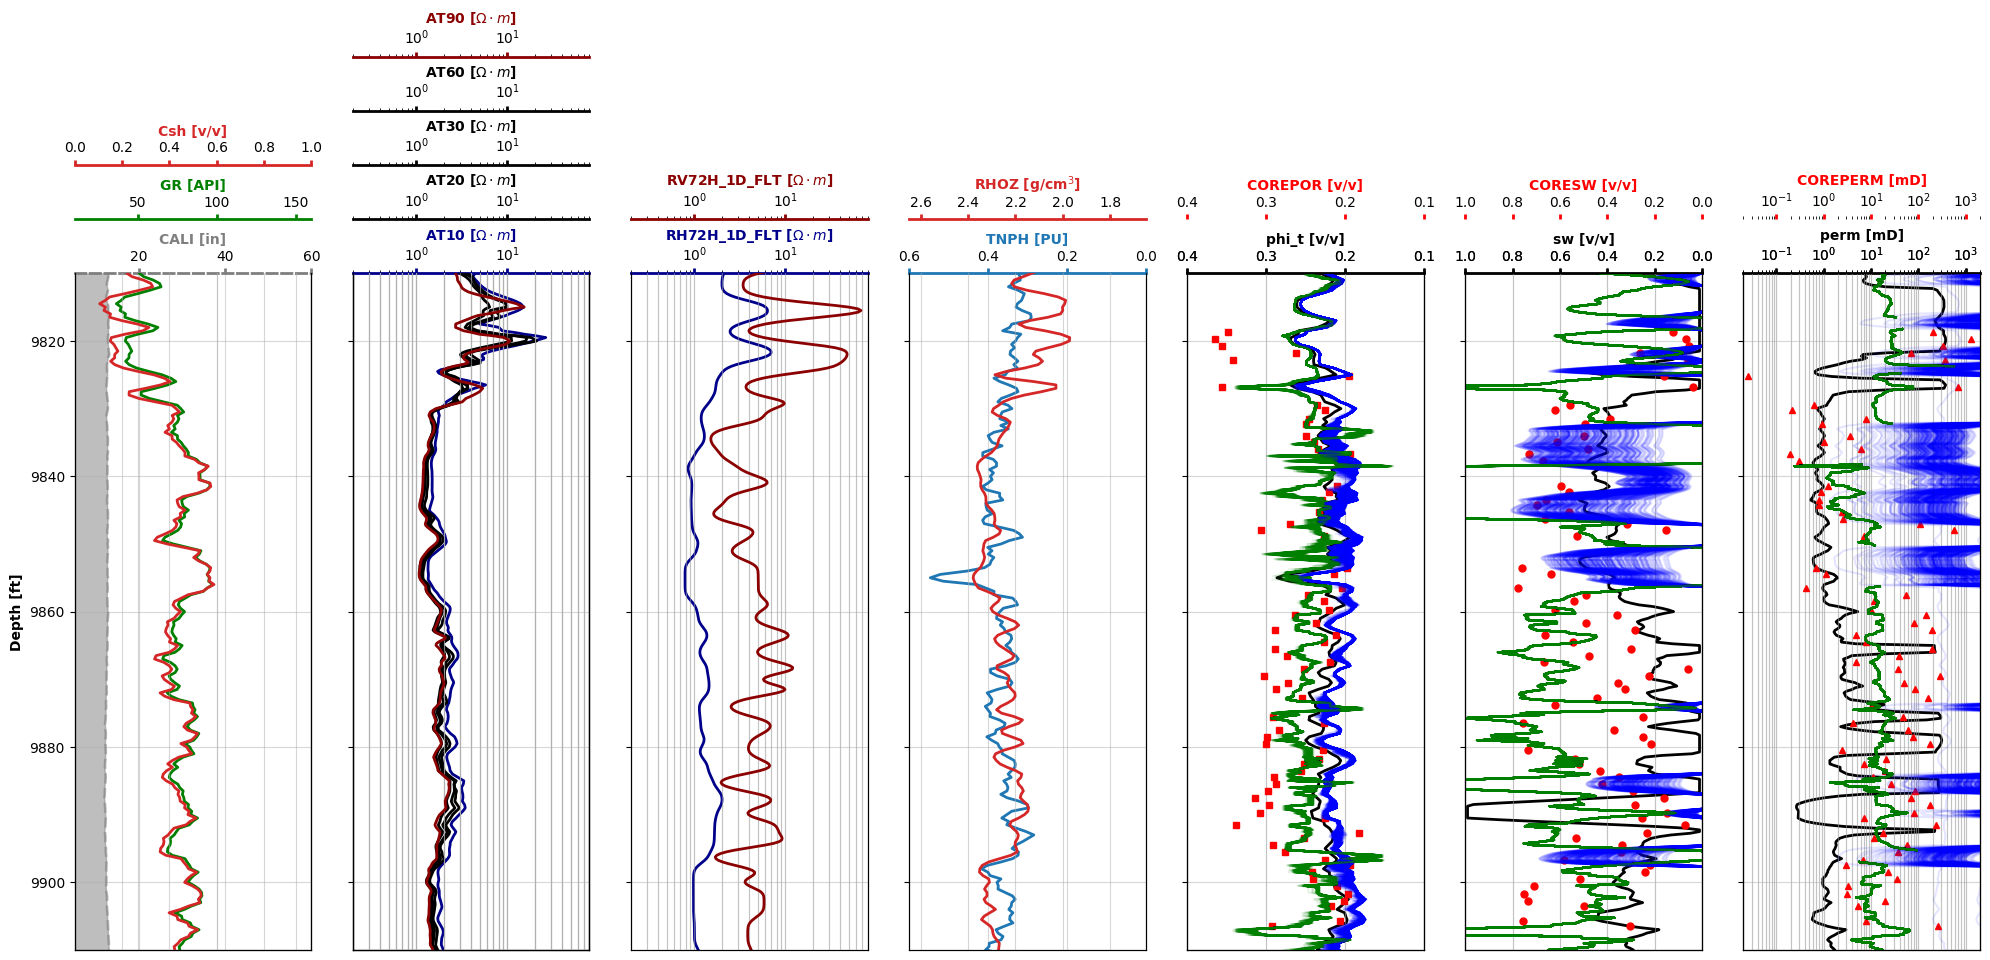

In [1150]:
rlb, rub = 0.2, 80
fig, axs = plt.subplots(1, 7, figsize=(20, 10), sharey=True)
ax1, ax2, ax3, ax4, ax5, ax6, ax7 = axs
ax11, ax12 = ax1.twiny(), ax1.twiny()
ax21, ax22, ax23, ax24 = ax2.twiny(), ax2.twiny(), ax2.twiny(), ax2.twiny()
ax31, ax41, ax51, ax61, ax71 = ax3.twiny(), ax4.twiny(), ax5.twiny(), ax6.twiny(), ax7.twiny()
ax52, ax62, ax72 = ax5.twiny(), ax6.twiny(), ax7.twiny()

plot_curve(ax1, d1, 'CALI', lb=5, ub=60, units='in', color='tab:gray', ls='--', alpha=0.5, fill=True)
plot_curve(ax11, d1, 'GR', units='API', lb=10, ub=160, color='g', pad=8)
plot_curve(ax12, d1, 'igr', lb=0, ub=1, units='v/v', label='Csh', color='tab:red', pad=16)

plot_curve(ax2, d1, 'AT10', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkblue', semilog=True)
plot_curve(ax21, d1, 'AT20', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='k', semilog=True, pad=8)
plot_curve(ax22, d1, 'AT30', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='k', semilog=True, pad=16)
plot_curve(ax23, d1, 'AT60', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='k', semilog=True, pad=24)
plot_curve(ax24, d1, 'AT90', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkred', semilog=True, pad=32)

plot_curve(ax3, d1, 'RH72H_1D_FLT', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkblue', semilog=True)
plot_curve(ax31, d1, 'RV72H_1D_FLT', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkred', semilog=True, pad=8)

plot_curve(ax4, d1, 'TNPH', units='PU', lb=0.6, ub=0.0, color='tab:blue')
plot_curve(ax41, d1, 'RHOZ', units=r'g/cm$^3$', lb=2.65, ub=1.65, color='tab:red', pad=8)

plot_curve(ax5, d1, 'phi_t', lb=0.4, ub=0.1, units='v/v', color='k')
plot_curve(ax51, d1, 'COREPOR', lb=0.4, ub=0.1, units='v/v', color='r', ls='', marker='s', ms=5, pad=8)
for i in range(nuq):
    ax52.plot(poro_prior[i], res1.index, 'b', alpha=0.1)
    ax52.plot(poro_posterior[i], res1.index, 'g', alpha=0.1)
ax52.set(xlim=(0.4,0.1))

plot_curve(ax6, d1, 'sw', lb=1, ub=0, units='v/v', color='k')
plot_curve(ax61, d1, 'CORESW', lb=1, ub=0, units='v/v', color='r', ls='', marker='o', ms=5, pad=8)
for i in range(nuq):
    ax62.plot(sw_prior[i], res1.index, 'b', alpha=0.1)
    ax62.plot(sw_posterior[i], res1.index, 'g', alpha=0.1)
ax62.set(xlim=(1,0))

plot_curve(ax7, d1, 'perm', lb=0.02, ub=2000, units='mD', color='k', semilog=True)
plot_curve(ax71, d1, 'COREPERM', lb=0.02, ub=2000, units='mD', color='r', ls='', marker='^', ms=5, semilog=True, pad=8)
for i in range(nuq):
    ax72.plot(perm_prior[i]*1e2, res1.index, 'b', alpha=0.1)
    ax72.plot(perm_posterior[i]*1e2, res1.index, 'g', alpha=0.1)
ax72.set(xlim=(0.02,2000), xscale='log')

ax1.set_ylabel('Depth [ft]', color='k', weight='bold')
ax1.set_ylim(9810, 9910)
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

***
# Dataset 2 analysis

In [1147]:
# North Sea (project)
d2 = lasio.read('datasets/project_data/25_10-16 S.LAS').df().dropna()
c2 = lasio.read('datasets/project_data/25_10-16 S_Core.las').df()

In [1148]:
sand_point, shale_point = 6828.0, 7510.5
print('Shale point: {:.1f} | Sand point: {:.1f}'.format(shale_point, sand_point))

# Csh (gamma ray index 'igr')
gmin, gmax = d2['HCGR'].min(), d2['HCGR'].max()
d2['igr'] = (d2['HCGR'] - gmin) / (gmax - gmin)
csh = MinMaxScaler((0.005,0.995)).fit_transform(d2['igr'].values.reshape(-1, 1)).flatten()

# porosity
d2['PHID_SS'] = (2.65 - d2['RHOZ'].dropna()) / (2.65 - 1)
phi_d_corr = (d2['PHID_SS'] - csh * d2.loc[shale_point, 'PHID_SS']) / (1-csh)
phi_n_corr = (d2['TNPH'] - csh * d2.loc[shale_point, 'TNPH']) / (1-csh)
phi_ss = 0.5*np.sqrt(phi_d_corr**2 + phi_n_corr**2)
d2['phi_t'] = (1-csh)*phi_ss + csh*phi_ss.loc[shale_point]

# resistivity & saturation
a, m, n = 1.0, 2.3, 2.0
rw = d2['AT90'][sand_point] * d2['PHID_SS'][sand_point]**m
rs = (1-csh) / ((1/d2['AT10'])-(csh/d2['AT10'].loc[shale_point]))
sw = ((a*rw) / (rs*d2['phi_t']**m))**(1/n)
d2['sw'] = sw.interpolate('polynomial', order=5).clip(0.01,0.99)
d2['shc'] = 1-d2['sw']

# permeability | a[100,1000], b[2,4], c[1.5,4]
aa, bb, cc = 10, 2.5, 1.5
d2['perm'] = (aa * d2['phi_t']**bb) / (d2['sw']**cc)

Shale point: 7510.5 | Sand point: 6828.0


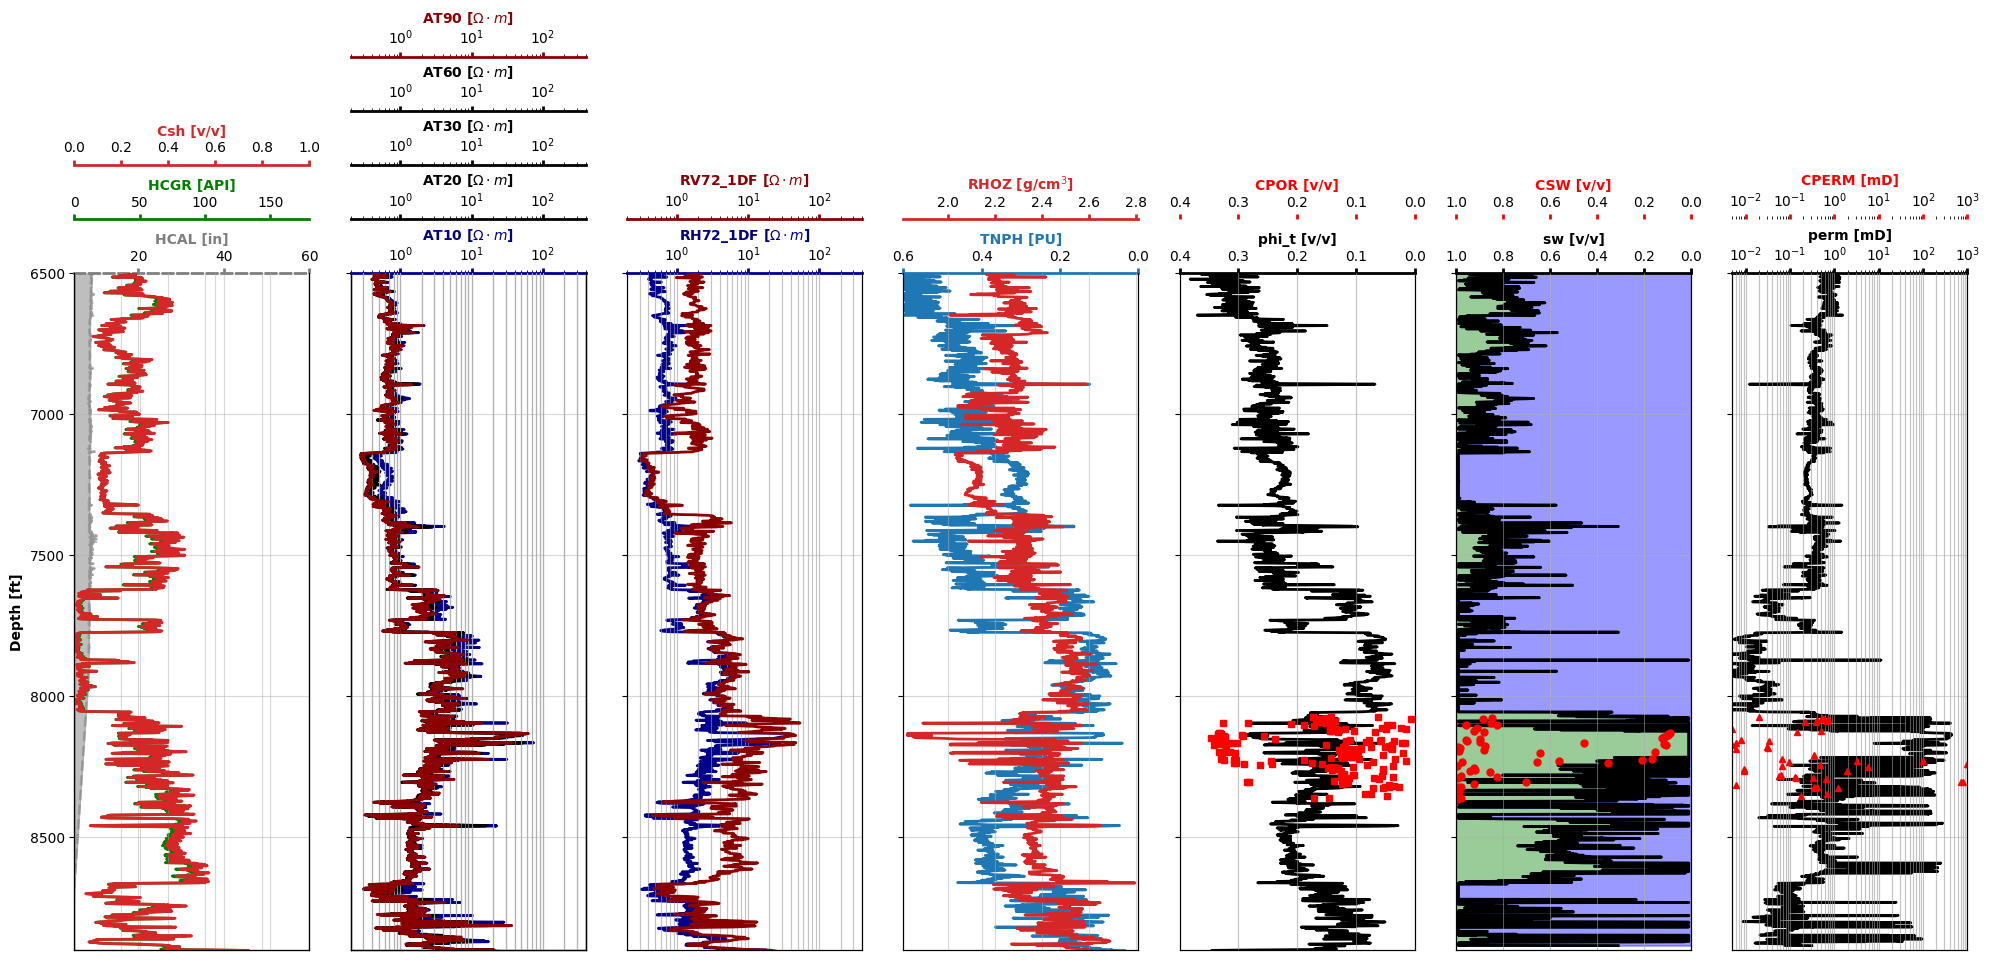

In [1149]:
rlb, rub = 0.2, 400
fig, axs = plt.subplots(1, 7, figsize=(20, 10), sharey=True)
ax1, ax2, ax3, ax4, ax5, ax6, ax7 = axs
ax11, ax12 = ax1.twiny(), ax1.twiny()
ax21, ax22, ax23, ax24 = ax2.twiny(), ax2.twiny(), ax2.twiny(), ax2.twiny()
ax31 = ax3.twiny()
ax41 = ax4.twiny()
ax51 = ax5.twiny()
ax61 = ax6.twiny()
ax71 = ax7.twiny()

plot_curve(ax1, d2, 'HCAL', lb=5, ub=60, units='in', color='tab:gray', ls='--', alpha=0.5, fill=True)
plot_curve(ax11, d2, 'HCGR', lb=0, ub=180, units='API', color='g', pad=8)
plot_curve(ax12, d2, 'igr', lb=0, ub=1, units='v/v', label='Csh', color='tab:red', pad=16)

plot_curve(ax2, d2, 'AT10', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkblue', semilog=True)
plot_curve(ax21, d2, 'AT20', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='k', semilog=True, pad=8)
plot_curve(ax22, d2, 'AT30', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='k', semilog=True, pad=16)
plot_curve(ax23, d2, 'AT60', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='k', semilog=True, pad=24)
plot_curve(ax24, d2, 'AT90', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkred', semilog=True, pad=32)

plot_curve(ax3, d2, 'RH72_1DF', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkblue', semilog=True)
plot_curve(ax31, d2, 'RV72_1DF', units=r'$\Omega\cdot m$', lb=rlb, ub=rub, color='darkred', semilog=True, pad=8)

plot_curve(ax4, d2, 'TNPH', lb=0.6, ub=0.0, units='PU', color='tab:blue')
plot_curve(ax41, d2, 'RHOZ', lb=1.81, ub=2.81, units=r'g/cm$^3$', color='tab:red', pad=8)

plot_curve(ax5, d2, 'phi_t', lb=0.4, ub=0.0, units='v/v', color='k')
plot_curve(ax51, c2, 'CPOR', lb=0.4, ub=0.0, units='v/v', color='r', ls='', marker='s', ms=5, pad=8)

plot_curve(ax6, d2, 'sw', lb=1, ub=0, units='v/v', color='g', fill=True, alpha=0.4)
plot_curve(ax6, d2, 'sw', lb=1, ub=0, units='v/v', color='b', fill=True, rightfill=True, alpha=0.4)
plot_curve(ax6, d2, 'sw', lb=1, ub=0, units='v/v', color='k')
plot_curve(ax61, c2, 'CSW', lb=1, ub=0, units='v/v', color='r', ls='', marker='o', ms=5, pad=8)

plot_curve(ax7, d2, 'perm', lb=0.005, ub=1000, units='mD', color='k', semilog=True)
plot_curve(ax71, c2, 'CPERM', lb=0.005, ub=1000, units='mD', color='r', ls='', marker='^', ms=5, semilog=True, pad=8)

ax1.set_ylabel('Depth [ft]', color='k', weight='bold')
ax1.set_ylim(6500, 8900)
ax1.invert_yaxis()
plt.tight_layout()
plt.show()

***
# END